In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import tensorflow as tf
import keras
get_ipython().run_line_magic('matplotlib', 'inline')
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from skimage.transform import resize
import seaborn as sns
import cv2

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict

In [3]:
trainData = unpickle(r'C:\Users\Dwaipayan Nandi\OneDrive\Desktop\projects\CIPHAR-100\Dataset\train')
testData = unpickle(r'C:\Users\Dwaipayan Nandi\OneDrive\Desktop\projects\CIPHAR-100\Dataset\test')
metaData = unpickle(r'C:\Users\Dwaipayan Nandi\OneDrive\Desktop\projects\CIPHAR-100\Dataset\meta')

In [4]:
for item in trainData:
    print(item, type(trainData[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [5]:
print(len(trainData['data']))
print(len(trainData['data'][0]))

50000
3072


In [6]:
subCategory = pd.DataFrame(metaData['fine_label_names'], columns=['SubClass'])
subCategory

,SubClass
0,apple
1,aquarium_fish
2,baby
3,bear
4,beaver
...,...
95,whale
96,willow_tree
97,wolf
98,woman


In [7]:
X_train = trainData['data']
X_train

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

In [8]:
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)

In [9]:
#transforming the testing dataset
X_test = testData['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
X_test.shape

(10000, 32, 32, 3)

In [10]:
y_train = trainData['fine_labels']
#y_train

y_test = testData['fine_labels']
#y_test

In [11]:
num_class = 100

y_train = keras.utils.to_categorical(y_train, num_class)
#y_train

y_test = keras.utils.to_categorical(y_test, num_class)
#y_test

In [12]:
X_train = X_train / 255.
#X_train

X_test = X_test / 255.
#X_test

In [13]:
# initializing CNN model 3
model = Sequential()

#Stack 1
#convolution
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
#pooling
model.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model.add(Dropout(0.2))

#Stack 2
#convolution
model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
#pooling
model.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model.add(Dropout(0.3))

#Stack 3
#convolution
model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
#pooling
model.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model.add(Dropout(0.3))

#Stack 4
#convolution
model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
#pooling
model.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model.add(Dropout(0.3))


#flattening
model.add(Flatten())

#full connection
model.add(Dense(units=2000, activation="relu"))
#dropout
model.add(Dropout(0.3))

#full connection
model.add(Dense(units=1000, activation="relu"))
#dropout
model.add(Dropout(0.3))

#full connection
model.add(Dense(units=500, activation="relu"))
#dropout
model.add(Dropout(0.3))


#output layer
model.add(Dense(units=num_class, activation="softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                        

In [15]:
epochs = 100
batch_size = 64

In [16]:
optimizer = keras.optimizers.Adam(lr=0.0001)

#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Anaconda3\envs\tensorgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#saving the model checkpoint for the best model
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [18]:
#image augmentation to expand the training dataset
#validation split to test the model
data_gen = ImageDataGenerator(
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            featurewise_center=True,
            width_shift_range=0.1,
            validation_split=0.2)

data_gen.fit(X_train, seed=123)

train_data_gen = data_gen.flow(X_train, y_train,
                               batch_size=batch_size,
                               subset="training", seed=123)

valid_data_gen = data_gen.flow(X_train, y_train,
                               batch_size=batch_size,
                               subset="validation", seed=123)

In [19]:
model_history = model.fit(train_data_gen,
                          steps_per_epoch=40000//batch_size,
                          validation_data=valid_data_gen,
                          validation_steps=10000//batch_size,
                          callbacks=[early_stop, model_checkpoint],
                          verbose=1,
                          epochs=epochs)

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 4.5101 - accuracy: 0.0150
Epoch 1: val_loss improved from inf to 4.34487, saving model to best_model.h5
625/625 [==============================] - 18s 24ms/step - loss: 4.5101 - accuracy: 0.0150 - val_loss: 4.3449 - val_accuracy: 0.0208
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 4.2809 - accuracy: 0.0274
Epoch 2: val_loss improved from 4.34487 to 4.11277, saving model to best_model.h5
625/625 [==============================] - 15s 24ms/step - loss: 4.2809 - accuracy: 0.0274 - val_loss: 4.1128 - val_accuracy: 0.0456
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 4.0279 - accuracy: 0.0554
Epoch 3: val_loss improved from 4.11277 to 3.93353, saving model to best_model.h5
625/625 [==============================] - 15s 24ms/step - loss: 4.0279 - accuracy: 0.0554 - val_loss: 3.9335 - val_accuracy: 0.0732
Epoch 4/100
623/625 [============================>.] - ETA: 0s - los

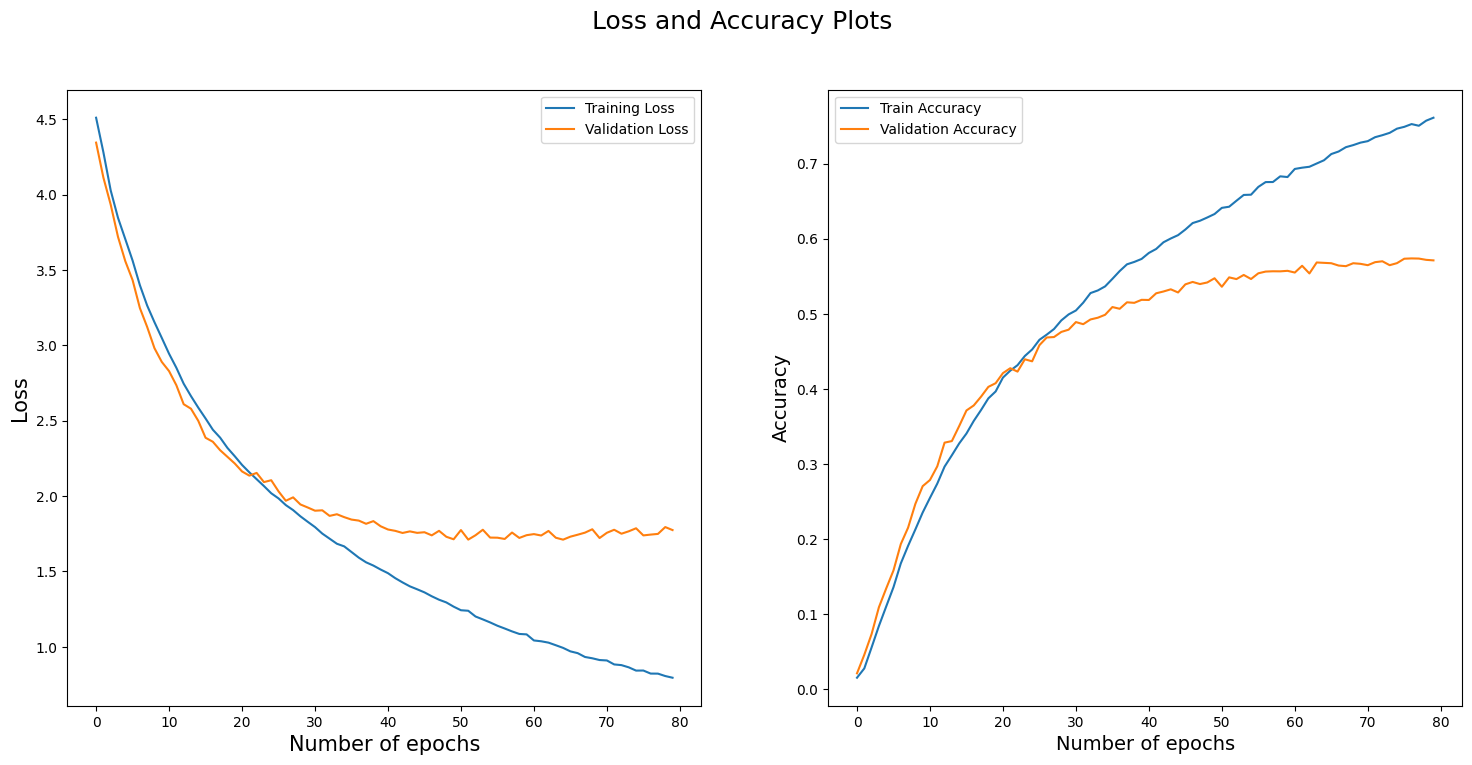

In [22]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [23]:
#train_loss, train_accuracy = model.evaluate_generator(generator=train_data_gen, steps=40000//batch_size)
valid_loss, valid_accuracy = model.evaluate_generator(generator=valid_data_gen, steps=10000//batch_size)
test_loss, test_accuracy = model.evaluate_generator(data_gen.flow(X_test, y_test, seed=123), steps=len(X_test)//batch_size)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")
print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")
print(" ")
print('Validation Loss: ', round(valid_loss, 2))
print('Test Loss: ', round(test_loss, 2))

C:\Users\Dwaipayan Nandi\AppData\Local\Temp\ipykernel_14468\2992606394.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_accuracy = model.evaluate_generator(generator=valid_data_gen, steps=10000//batch_size)
C:\Users\Dwaipayan Nandi\AppData\Local\Temp\ipykernel_14468\2992606394.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(data_gen.flow(X_test, y_test, seed=123), steps=len(X_test)//batch_size)


Validation Accuracy:  57.52 %
Test Accuracy:  56.93 %
 
Validation Loss:  1.75
Test Loss:  1.75
